<div align="center">

# **MICRO - 452 : Basics of Mobile robotics**
### **Project**

**Paul Huot-Marchand** <br>
**Luca Seelbach**<br>
**Manuela Waible** <br>
 

**Date:** *Automn 2025*
</div>

# **INTRODUCTION**
Our project take place on a rectangular white environment with black obstacles of any shapes a black circle as goal and a  black isocele triangle on the robot. The goal was to implement global navigation using the camera provided creating a global occupancy map, then applying an A* algorithm to find an optimized path. A filter was implemented to track position of the robot. Local avoidance was implemented to avoid la minuit added obstacles using thymio infrared sensors.

## Work repartition : 
### Computer Vision :
Attributed to : <b>Paul </b>

### Filtering : 
Attributed to : <b>Manuela</b>
### Global Navigation : 
Attributed to : <b>Luca</b>

### Local Navigation : 
Goal : Using IR sensors, detect for unexpected obstacles and correct trajectory accordingly 
Attributed to : <b>Luca</b>

### Motion : 
Goal : Using diverse inputs from global navigation and filtering to determine motor commands 
Attributed to : <b>Manuela</b>
## 1. Objectifs 
The goal of this project is to use the Thymio robot and a camera to : 
- Create a map of an environment 
- Detect the starting position and target position in the environemnt
- Calculate a global path
- Move the robot towards the target location while avoiding obstacles (permanent and movable) 
- Be insensitive to Kidnapping and camera obscuring 

## 2. Environement : 
For the environment, we chose to have a large white paper sheet with black obstacles to be less sensitive to lighting condition. The only conditions we set on the obstacles where that they are not an isosceles triangle nor round since those shapes are reserved respectively for the robot and the end goal.  We also consider the borders of the sheet as obstacles so that the robot never exists the environement. Local obstacles are defined in various sizes and shapes, like square or round objects.
<div align="center">
<img src="Report_images/Environnement.png" style="transform: rotate(-90deg)" width=500px>
</div>


# Libraries

In [ ]:
!pip install tdmclient numpy scipy opencv-python tqdm


In [1]:
import numpy as np
from scipy.ndimage import distance_transform_edt
import cv2
import tqdm
from Computer_vision import cv as com
#import Filtering as flt 
from Global_Nav import global_nav as gb
import matplotlib.pyplot as plt

import math as m
import numpy as np
from collections import deque
from matplotlib.animation import FuncAnimation

from Filtering import Control_fromEKF as control
from Filtering import Filtering as filt
from Local_Nav import local_nav as ln



In [ ]:
# Initiate the communication between the Thymio and the computer
from tdmclient import ClientAsync, aw
client = ClientAsync()

node = await client.wait_for_node()
await node.lock() 

## Constants

In [ ]:
#all of this not necessary

def length_real_to_pixel(length_cm, env_size_cm, map_size):
    
    L, W = env_size_cm
    height, width = map_size
    
    # scale factors
    scale_x = width / L
    scale_y = height / W
    
    # average scale for uniform scaling
    scale = (scale_x + scale_y) / 2
    
    return length_cm * scale

#================HYPERPARAMETESRS======================
## COMPUTER VISION ## 

#SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]

#SIZE OF THE TRIANGLE (cm)
L_T = 10
H_T = 3.5
L_T_p = length_real_to_pixel(L_T,[L,W], SIZE)
H_T_p = length_real_to_pixel(H_T,[L,W], SIZE)

#SIZE OF THE GOAL (cm)
R_G = 8.4/2

R_G_p = length_real_to_pixel(R_G,[L,W], SIZE)

# AREA RATIO
RATIO_T = (L_T*H_T/2) / (L*W) 

#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 5
B2_O = 50
B3_O = 50
C1_O = 0.5
C2_O = 1.5
M1_O = 8
CL1_O = 2.0
M_O = 5
D_O = 5

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 8
B2_C = 70
B3_C = 70
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0
M_C = 5
D_C = 5

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 80
B3_T = 80
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_T = 2
M_T = 2
D_T = 2


#PARAMETERS TO DETECT THE ENV
#Min_area_env = 1920*1080*0.01   #Min area in pixel of the env
Min_area_env = 1000
Env_approx = 0.1

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = SIZE[0]*SIZE[1]*0.005   #Min area in pixel of the env
Max_area_obs = SIZE[0]*SIZE[1]*0.5   #Max area in pixel of the env
Obs_approx = 0.01

#PARAMETERS TO DETECT GOAL
Min_area_goal = np.pi * R_G_p * R_G_p *0.8
Max_area_goal = np.pi * R_G_p * R_G_p * 1.8

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = (L_T_p*H_T_p /2) * 0.2   #Min area in pixel of the env
Max_area_rob =  (L_T_p*H_T_p /2) * 1.8
Rob_approx = 0.08

#ROBOT CARACTERISTICS
R_ROBOT = 6
R_ROBOT_p = length_real_to_pixel(R_ROBOT,[L,W], SIZE)


#SYMBOLS FOR THE MAP
FREE_SPACE = 0
OCCUPIED_SPACE = -1
GOAL = -3

DEBUG = False

# Global Navigation 
MAP_SCALE = 0.5 # in cm/px
#========================================================


## Computer Vision : 

**INSERT EXPLENATION HERE WITH CODE EXAMPLES AND ALL THE HYPOTHESIS AND MATH BEHIND EVERYTHING**

In [ ]:
# connect to camera

if DEBUG : 
    import matplotlib.pyplot as plt
    %matplotlib inline
#GLOBAL FRAMEWORK TO USE VISION
#EXECUTE CELL ABOVE WITH DEBUG = TRUE FOR TUNING UNTIL EVERYTHING IS CORRECTLY FILTERED AND FOUND
cap = cv2.VideoCapture(1)
    
if not cap.isOpened():
    print("Could not access webcam")

## **I Computer Vision**
The steps of our computer vision part is as follow : 
- Detect the environment,
- Correct percpective,
- detect obstacles and goal to fill occupancy map
- detect the robot

To do so a general filtering framework was adopted. First convert to gray scale, apply bilateral filter to enhance edge and remove noise, apply canny filter to detect edges, apply morphological filter to close as much as possib

ROBOT FOUND
MAP ANALYZED : 
GOAL FOUND
ROBOT FOUND


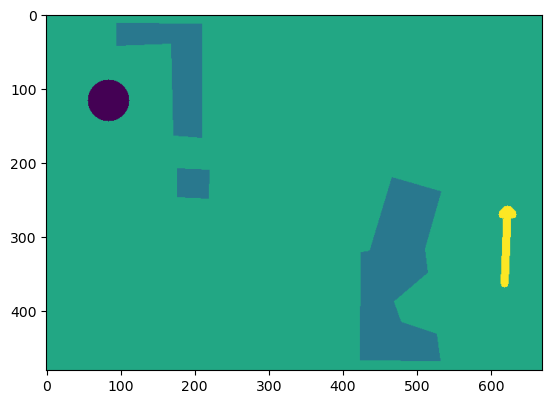

In [7]:
#INITIALIZATION
#GET A FRAME
img = com.get_picture_optimized(cap)
#img = cv2.imread("02.png")
#COMPUTE TRANSFORMATION MATRIX
matrix = com.matrix_perspective(img)
#CORRECT IMAGE
transformed_image = com.convert_perspective(img,matrix)

#PLOTTING
if DEBUG: 
    plt.figure()
    plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
    plt.title("Perspective Corrected Image")
    plt.axis('off')
    plt.show()


#GET GLOBAL MAP
global_map = com.get_map(transformed_image)

#GET ROBOT POSITION AND ORIENTATION
robot = com.get_robot(transformed_image)


length = 100
end_x = int(robot[0][0] + length * np.cos(robot[1]))
end_y = int(robot[0][1] + length * np.sin(robot[1]))
end_point = (end_x, end_y)
global_map4plot = global_map.copy()
cv2.arrowedLine(global_map4plot, [int(robot[0][0]), int(robot[0][1])], end_point, color=(2, 2, 2), thickness=10)
plt.imshow(global_map4plot)
plt.show()
if DEBUG : 
    global_map4plot = global_map.copy()
    cv2.arrowedLine(global_map4plot, robot[0], end_point, color=(2, 2, 2), thickness=10)
    plt.imshow(global_map4plot)
    plt.axis('off')
    plt.show()


## Global Navigation 
For the global navigation, we decided to keep it as simple as possible while having decent performances. For that, the most modular and performant algorithm was A*, since complexity can easily be controlled by the intricacy of the motion cost, while guranteeing fast path calculations, especially if set as depth first. 

For that reason, we decided to have a grid map, using every pixel of the image as cell, and the center of the robot as reference point. We then increase the size of the obstacles to account for that. 

Another reason for the A* choice was motivated by the fact that it is a very popular and used algorithm, with lots of examples and documentation about various ways to implement it. We heavily used the pseudo-code provided by <a href="https://en.wikipedia.org/wiki/A*_search_algorithm"> the Wikipedia A star</a> page.

We defined the heuristic and motion cost function as such : 

$h(n) = distance(n, goal) = L_2\{n, goal\}$
<br>

$g(n) = g(n-1) + distance(n, previous\ cell) + \frac{4(\alpha_{n} - \alpha_{c})}{\pi}$

Where the distance from the previous cell is the euclidean distance between the cell we came from to the cell we are studying, $\alpha_c$ is the current angle of the robot and $alpha_n$ is the angle that the robot needs to have in order to move to the next cell. For example, if the robot is at a cell [1, 3] and is facing right as a starting point, that means that the current angle is 0 and g(n) = 0. If we are studying the cell [2, 4], then : 

$g(n) = 0 + \sqrt{(2-3)^2 + (4-3)^2} + \frac{4\cdot{}(atan(\frac{4-3}{2-3}))- 0}{\pi} = 0 + \sqrt{2} + 1 = 2.4142...$

Since we are using a grid map, the only possible directions are multiples of $\frac{\pi}{4}$ and the linear distances are either 1 or $\sqrt{2}$, which simplifies a lot the calculations. A more complexe algorithm that

We have read that it is very common practice to use a heap to manage the discovered cells as well as their f scores, so we used the python built-in library *heapq* for that purpose. 

In [ ]:
def a_star (env_map_orig : list[list], alpha_init, cm_px_scale, start) : 
    MAP_SIZE = (len(env_map_orig), len(env_map_orig[0])) 
    end = get_end(env_map_orig)
    h_map = distance_map(env_map_orig, start)
    env_map = obstacle_scale(env_map_orig.copy(), cm_px_scale)
    open_set = []
    heappush(open_set, (h_map[start[0]][start[1]],0, start)) #heap is (f, g, current)
    came_from = {}
    g_score = {start : (0, alpha_init)}
    counter = 0
    while open_set : 
        counter = counter + 1
        f, g, current = heappop(open_set)
        if current == end : 
            path = reconstruct_path(current, came_from, start)
            return path
        x,y = current
        for dx, dy in [(1,0), (-1,0), (0,1), (0,-1), (1,1), (-1,1), (1,-1), (-1,-1)] :
            nx, ny = x + dx, y+dy 
            if not((0 <= nx < MAP_SIZE[0]) and (0<= ny < MAP_SIZE[1])) :
                continue
            if env_map[nx][ny] == -1 :
                continue
            alpha = m.atan2(dy, dx)
            new_g = (motion_cost(g_score[current], alpha))
            xplore = (nx,ny)
            if xplore not in g_score or new_g < g_score[xplore][0] : 
                try : 
                    g_score[xplore] = (new_g, alpha)
                    f = new_g + h_map[nx][ny]
                    heappush(open_set, (f, new_g, xplore))
                    came_from[xplore] = current
                except IndexError : 
                    print(f"ALL INDEXES ARE : {nx}, {ny}, {xplore}")

In [ ]:
path = gb.a_star(global_map, alpha_init=robot[1], cm_px_scale=MAP_SCALE, 
                 start=(int(round(robot[0][1])), int(round(robot[0][0]))))

480
670
158
98


In [ ]:
# final loop that runs everything
import cv2
from tdmclient import aw
from main import main


cap = cv2.VideoCapture(1)


if not cap.isOpened():
    print("Could not access webcam")
    
# run main
aw(main(cap))

# Release resources
#cap.release()
cv2.destroyAllWindows()


ROBOT FOUND
MAP ANALYZED : 
GOAL FOUND
ROBOT FOUND
480
670
351
390
319215
ROBOT FOUND
Connected: Node 7e5a04de-7cbe-4397-8545-f33016b69c2f
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOUND
ROBOT FOU

In [ ]:
# to stop it
aw(node.set_variables({"motor.left.target":[0], "motor.right.target":[0]}))
aw(node.unlock())

![final path with camera frame, converted map frame and path plan/execution frame](pathtest.png)